# Activity recognition on the Capture24 dataset

We aim to build a machine learning model to recognize
activities from wrist-worn accelerometer measurements.
Our baseline model is a random forest trained to classify instances of 30
seconds of activity, trained on the hand-crafted features `X_feats`. Further,
we use a Hidden Markov Model to account for temporal dependencies to smooth
the predictions of the random forest.

###### Setup

In [1]:
import numpy as np
from scipy.stats import mode
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import utils  # contains helper functions for this workshop -- check utils.py

# For reproducibility
np.random.seed(42)

 ###### Load dataset and hold out some instances for testing 

In [2]:
data = np.load('capture24.npz', allow_pickle=True)
# data = np.load('capture24_small.npz', allow_pickle=True)
print("Contents of capture24.npz:", data.files)
X, y, pid, time = data['X_feats'], data['y'], data['pid'], data['time']

# Hold out some participants for testing the model
pids_test = [2, 3]  # participants 2 & 3
mask_test = np.isin(pid, pids_test)
mask_train = ~mask_test
X_train, y_train, pid_train, time_train = \
    X[mask_train], y[mask_train], pid[mask_train], time[mask_train]
X_test, y_test, pid_test, time_test = \
    X[mask_test], y[mask_test], pid[mask_test], time[mask_test]
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)

Contents of capture24.npz: ['X_feats', 'y', 'pid', 'time', 'annotation']
Shape of X_train: (325619, 125)
Shape of X_test: (4991, 125)


 ###### Train a random forest classifier

*Note: this takes a few minutes*

In [3]:
# Argument oob_score=True to be used for HMM smoothing (see below)
classifier = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=4, verbose=True)
classifier.fit(X_train, y_train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  3.7min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
                       oob_score=True, random_state=None, verbose=True,
                       warm_start=False)

 ###### Evaluate model on held-out participants

In [4]:
y_test_pred = classifier.predict(X_test)
print("\n--- Random forest performance ---")
utils.print_scores(utils.compute_scores(y_test, y_test_pred))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished



--- Random forest performance ---
Accuracy score: 0.8639551192145862
Balanced accuracy score: 0.6314648800499794
Cohen kappa score: 0.7828338262293296

Per-class recall scores:
sleep      : 0.9185684647302904
sedentary  : 0.9311121116614138
tasks-light: 0.0234375
walking    : 0.5193548387096775
moderate   : 0.7648514851485149

Confusion matrix:
 [[1771  154    0    2    1]
 [ 103 2068    9   35    6]
 [   3  104    3   12    6]
 [   1   70   20  161   58]
 [   0   59   12   24  309]]


From the per-class recall scores, we see that the model does a descent job in
detecting moderate activity and a very good job in detecting sleep and
sedentary activities. However, the model has difficulty in detecting
'tasks-light' activities.
Also, because our dataset is highly unbalanced, we see a large difference
between the (unbalanced) accuracy and balanced accuracy scores.

###### Plot predicted and true activity timeseries

Using our utility function, we plot the activity timeseries for participant #3. Here we also pass the first hand-crafted feature (first column of `X`) containing the mean acceleration for plotting.

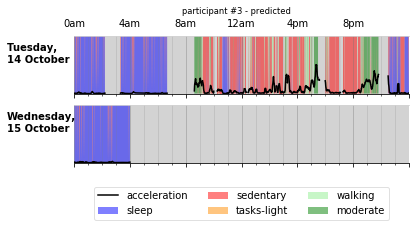

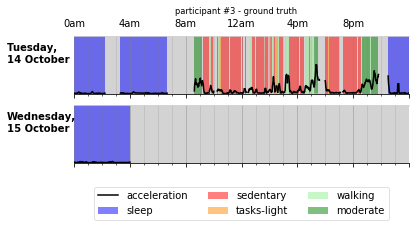

In [5]:
# Activity plot for participant #3 -- predicted
fig, _ = utils.plot_activity(
    X_test[pid_test==3][:,0], y_test_pred[pid_test==3], time_test[pid_test==3]
)
fig.suptitle('participant #3 - predicted', fontsize='small')
fig.show()

# Activity plot for participant #3 -- ground truth
fig, _ = utils.plot_activity(
    X_test[pid_test==3][:,0], y_test[pid_test==3], time_test[pid_test==3]
)
fig.suptitle('participant #3 - ground truth', fontsize='small')
fig.show()

## Accounting for temporal dependencies to smooth the predictions

The random forest classifier performs descently well.
However, the model does not account for temporal dependencies since we simply
trained it to independently classify intervals of 30 seconds of activity.
This can be seen in the activity plot where the sleep period is not smooth.

###### Mode filtering
To account for the temporal component, we first consider smoothing the predictions
by applying a mode filter, i.e. we pass a window (here of size 3) through the
predicted activity timeseries and pick the most popular activity within the
window.

**Note:** As mentioned before, the provided arrays `X_feats`, `X_raw`, `y`, etc. are so that consecutive rows correspond to continuous measurements in time for a same participant.
Discontinuities will naturally occur at the edges between two participants.
Interrupts in the measurement within a same participant may also occur (e.g. device run out of battery).
In the following time smoothing approaches we do not account for these interrupts &mdash; the number of these are negligible so we ignore them. You could properly account for these by looking at the `time` and `pid` arrays.


--- Random forest performance with mode filtering ---
Accuracy score: 0.8839911841314366
Balanced accuracy score: 0.6350127936583144
Cohen kappa score: 0.8131360224656646

Per-class recall scores:
sleep      : 0.9496887966804979
sedentary  : 0.9513732552904097
tasks-light: 0.0
walking    : 0.4967741935483871
moderate   : 0.7772277227722773

Confusion matrix:
 [[1831   96    0    1    0]
 [  82 2113    2   23    1]
 [   2  120    0    3    3]
 [   3   95   12  154   46]
 [   0   69    5   16  314]]


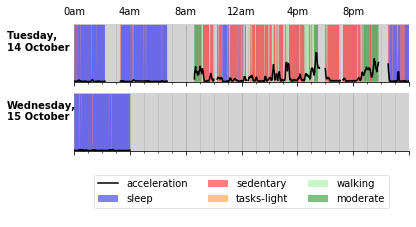

In [6]:
y_test_modefilt = mode(
    np.vstack((y_test_pred[:-2], y_test_pred[1:-1], y_test_pred[2:])),
    axis=0)[0].ravel()
y_test_modefilt = np.concatenate(([y_test_pred[0]], y_test_modefilt, [y_test_pred[-1]]))
print("\n--- Random forest performance with mode filtering ---")
utils.print_scores(utils.compute_scores(y_test, y_test_modefilt))

fig, _ = utils.plot_activity(
    X_test[pid_test==3][:,0], y_test_modefilt[pid_test==3], time_test[pid_test==3]
)
fig.show()

###### Hidden Markov Model

We see that the simple mode smoothing improves the summary scores and the activity plot is now smoother.

A more principled approch is to use a Hidden Markov Model (HMM). Here we
assume that the random forest predictions are mere "observations" of the
"hidden ground truth".
HMM requires that we obtain prior, emission and transition matrices. We can
compute these using the ground truth labels `y_train` together with the
classifier's probabilistic predictions on the training set (`predict_proba()`).
We use our utility functions `train_hmm()` and `viterbi()` to obtain these matrices and smoothing &mdash; see `utils.py` for details.

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    4.1s finished



--- Random forest performance with HMM smoothing (in-bag estimate) ---
Accuracy score: 0.9076337407333199
Balanced accuracy score: 0.6672541752766287
Cohen kappa score: 0.8522497096656845

Per-class recall scores:
sleep      : 0.9740663900414938
sedentary  : 0.9635299414678073
tasks-light: 0.0
walking    : 0.5645161290322581
moderate   : 0.8341584158415841

Confusion matrix:
 [[1878   45    0    5    0]
 [  53 2140    0   27    1]
 [   0  121    0    5    2]
 [   0   76    0  175   59]
 [   0   40    0   27  337]]


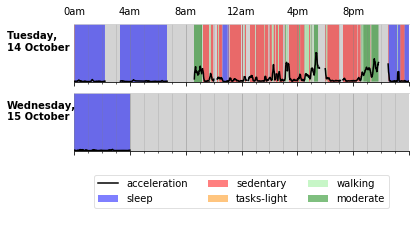

In [7]:
Y_train_pred = classifier.predict_proba(X_train)  # probabilistic predictions -- this is a (N,5) array
prior, emission, transition = utils.train_hmm(Y_train_pred, y_train)  # HMM training step
y_test_hmm = utils.viterbi(y_test_pred, prior, emission, transition)  # smoothing
print("\n--- Random forest performance with HMM smoothing (in-bag estimate) ---")
utils.print_scores(utils.compute_scores(y_test, y_test_hmm))

fig, _ = utils.plot_activity(
    X_test[pid_test==3][:,0], y_test_hmm[pid_test==3], time_test[pid_test==3]
)
fig.show()

The HMM smoothing further improves the scores and the activity plot is even smoother.

Instead of using `predict_proba` on the same set that the model was trained on, the model conveniently provides out-of-bag probability estimates on the training set (enabled by passing the `oob_score=True` argument), accessible via the attribute `oob_decision_function_`. These estimations are closer to the actual out-of-sample performance of the model. We can use these to re-calculate the HMM parameters:


--- Random forest performance with HMM smoothing (out-of-bag estimate) ---
Accuracy score: 0.8994189541174114
Balanced accuracy score: 0.640193974688228
Cohen kappa score: 0.8386810836356542

Per-class recall scores:
sleep      : 0.9766597510373444
sedentary  : 0.9590274651058082
tasks-light: 0.0
walking    : 0.3741935483870968
moderate   : 0.8910891089108911

Confusion matrix:
 [[1883   45    0    0    0]
 [  53 2130    0   28   10]
 [   0  120    0    2    6]
 [   0  102    0  116   92]
 [   0   39    0    5  360]]


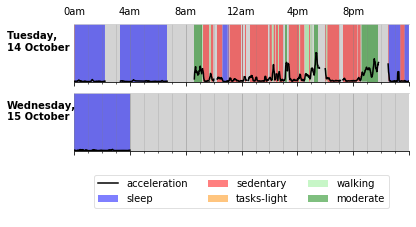

In [8]:
Y_oob = classifier.oob_decision_function_  # probabilistic predictions -- this is a (N,5) array
prior, emission, transition = utils.train_hmm(Y_oob, y_train)  # HMM training step
y_test_hmm_oob = utils.viterbi(y_test_pred, prior, emission, transition)  # smoothing
print("\n--- Random forest performance with HMM smoothing (out-of-bag estimate) ---")
utils.print_scores(utils.compute_scores(y_test, y_test_hmm_oob))

fig, _ = utils.plot_activity(
    X_test[pid_test==3][:,0], y_test_hmm_oob[pid_test==3], time_test[pid_test==3]
)
fig.show()

## Is a simple logistic regression enough?

*Note: this takes a few minutes*

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 177 epochs took 253 seconds

--- Logistic regression performance ---
Accuracy score: 0.6710078140653176
Balanced accuracy score: 0.4718274751395158
Cohen kappa score: 0.47227469460536387

Per-class recall scores:
sleep      : 0.9491701244813278
sedentary  : 0.5497523638000901
tasks-light: 0.0234375
walking    : 0.45806451612903226
moderate   : 0.3787128712871287

Confusion matrix:
 [[1830   86    1    2    9]
 [ 961 1221    3   26   10]
 [  25   85    3   13    2]
 [   9  117   13  142   29]
 [   9  183    4   55  153]]


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.2min finished


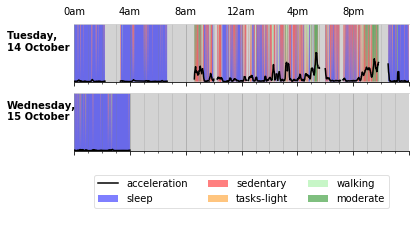

In [9]:
classifier_LR = LogisticRegression(
    random_state=42, solver='saga', multi_class='multinomial', max_iter=10000, n_jobs=1, verbose=True)
classifier_LR.fit(X_train, y_train)
y_test_LR = classifier_LR.predict(X_test)
print("\n--- Logistic regression performance ---")
utils.print_scores(utils.compute_scores(y_test, y_test_LR))

fig, _ = utils.plot_activity(
    X_test[pid_test==3][:,0], y_test_LR[pid_test==3], time_test[pid_test==3]
)
fig.show()

###### HMM smoothing on the logistic regression predictions


--- Logistic regression performance with HMM smoothing ---
Accuracy score: 0.7433380084151473
Balanced accuracy score: 0.5674730071851789
Cohen kappa score: 0.59515481670438

Per-class recall scores:
sleep      : 0.9994813278008299
sedentary  : 0.60018009905448
tasks-light: 0.0
walking    : 0.532258064516129
moderate   : 0.7054455445544554

Confusion matrix:
 [[1927    0    0    0    1]
 [ 849 1333    0   14   25]
 [   0  118    0    8    2]
 [   2  101    0  165   42]
 [   0   40    0   79  285]]


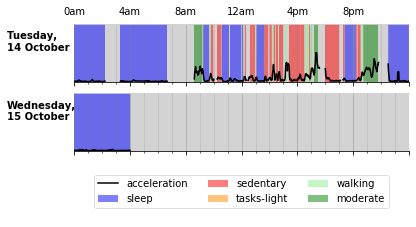

In [10]:
Y_train_LR_pred = classifier_LR.predict_proba(X_train)  # probabilistic predictions -- this is a (N,5) array
prior, emission, transition = utils.train_hmm(Y_train_LR_pred, y_train)  # HMM training step
y_test_LR_hmm = utils.viterbi(y_test_LR, prior, emission, transition)  # smoothing
print("\n--- Logistic regression performance with HMM smoothing ---")
utils.print_scores(utils.compute_scores(y_test, y_test_LR_hmm))

fig, _ = utils.plot_activity(
    X_test[pid_test==3][:,0], y_test_LR_hmm[pid_test==3], time_test[pid_test==3]
)
fig.show()

HMM on top of the logistic regression model substantially improves its
performance. But although the predictions are smooth, the performance is
still much worse than the random forest model.

## Conclusion

Random forest on the hand-crafted features shows very good performance in detecting sleep and sedentary behavior, but the remaining activity classes could be improved.
Smoothing the predictions to account for temporal dependencies reliably
improves performance. A simple logistic regression did not seem to perform as
well as the random forest (at least for the hyperparameters considered).

In the next sections, we ask you to improve our baseline using a variety of
approaches from the machine learning literature.
Note that now that we have repeatedly evaluated on the test set and taken decisions
based on it (we have abused the test set), the reported scores are no longer
an unbiased estimate of the general performance. A true test set will be
provided at the end of this workshop to truly assess the performance of your
model.

###### Ideas

- Can we improve performance by balancing the dataset?
- Tune hyperparameters of the random forest (`n_estimators`, `max_depth`,
`criterion`, etc.). See [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).
- How would you select the best set of hyperparameters?

###### References
- [A nice lecture on validation](https://www.youtube.com/watch?v=o7zzaKd0Lkk&hd=1)